# **Context Encoders**


## Load libraries, models

In [1]:
import numpy as np
from utils.load_dataset import get_all_datasets
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from model import ContextEncoder, Discriminator
from classifier import create_wildfire_classifier
from utils.utils_gan import get_mask, apply_mask, train_one_epoch, load_checkpoint, plot_comparison

In [139]:
def extract_masked(true, pred, mask, title):
    pred = pred.detach().cpu().numpy()
    zone_true = np.zeros((50,50,3))
    zone_pred = np.zeros((50,50,3))
    for i in range(3):
        zone_true[:,:,i] = true[0,i,...].flatten()[np.flatnonzero(1-mask[0,0])].reshape((50,50))
        zone_pred[:,:,i] = pred[0,i,...].flatten()[np.flatnonzero(1-mask[0,0])].reshape((50,50))

    plot_comparison(zone_true, zone_pred, title)

## Load data

In [2]:
dataset_path = Path('../data')
pretrain_path = dataset_path / 'train'
val_path = dataset_path / 'valid'
test_path = dataset_path / 'test'
data_transforms = {
    'pretrain': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrain_dataset, train_dataset, val_dataset, test_dataset = get_all_datasets(pretrain_path=pretrain_path,
                                                                              val_path=val_path,
                                                                              test_path=test_path,
                                                                              transforms_dict=data_transforms)

## Load model

In [3]:
pretrain_dataloader = DataLoader(pretrain_dataset, batch_size=16)
model = ContextEncoder()
discriminator = Discriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_check = '../checkpoints/context_encoder/context_encoder.pt'
load_checkpoint(path_check, model, discriminator)

/home/enzolouv/Documents/ENS PS 2024-2025/cours/computer_vision/project_wildfire/context_encoder/utils/utils_gan.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkp

## Visualize ContextEncoder performances

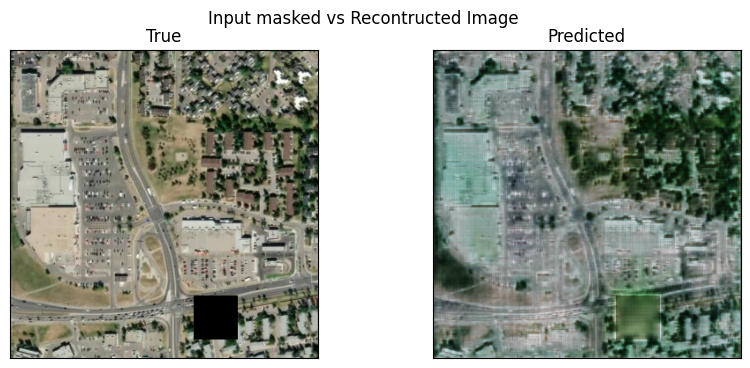

/tmp/ipykernel_68684/1174897730.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  zone_true[:,:,i] = true[0,i,...].flatten()[np.flatnonzero(1-mask[0,0])].reshape((50,50))


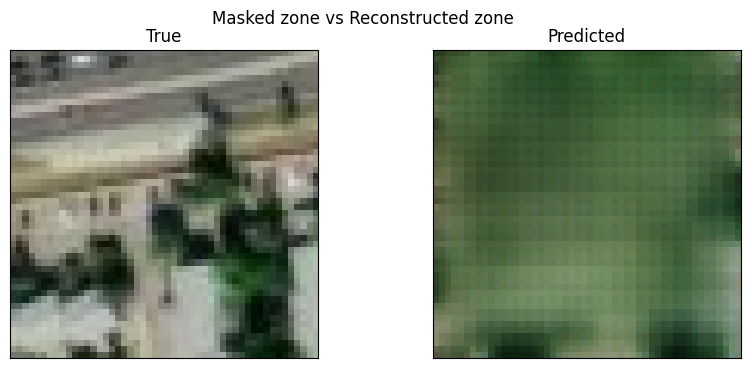

In [191]:
ds = train_dataset
idx = np.random.randint(0,len(ds))
true = ds[idx][0][None]
mask = get_mask(true.shape)
input_masked, output_masked_gt = apply_mask(true, mask)
pred = model(input_masked)
reconstructed = pred*(1-mask) + true*mask
plot_comparison(input_masked[0].permute(1,2,0).detach().cpu().numpy(),pred[0].permute(1,2,0).detach().cpu().numpy(), 'Input masked vs Recontructed Image')
plt.show()

extract_masked(true,reconstructed, mask, 'Masked zone vs Reconstructed zone')